In [79]:
import pandas as pd
import re
import os
import glob
import snapatac2 as snap

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import utils
import subprocess
from statsmodels.stats.multitest import multipletests


In [46]:
def summarize_mast(file="/data2st1/junyi/output/atac0526/dar/region_nt/mast/*PFC_PFC_Glut*.csv*",celltype='PFC_Glut'):
    mast_files = glob.glob(file)
    df_all = pd.DataFrame()
    for f in mast_files:
        df = pd.read_csv(f, index_col=0)
        df_h = df[(df.component=="H") & (df['Pr(>Chisq)'] < 0.05)]
        df_lfc = df[(df.component=='logFC') & (df['contrast'] =='exprimentMW') ]
        df_dar = df_h.loc[:,["primerid","Pr(>Chisq)"]].merge(df_lfc.loc[:,['primerid','ci.hi','ci.lo','coef','z']], on='primerid', how='left').dropna(axis=1, how='all').dropna()
        df_all = pd.concat([df_all, df_dar])
    # correct the pvalue by Benjamini-Hochberg method from scipy
    df_all['p_adj'] = multipletests(df_all['Pr(>Chisq)'], method='fdr_bh')[1]


    df_all = df_all[df_all.p_adj < 0.05].sort_values('coef')
    df_all_annotated = utils.annotate_region(df_all,region_col='primerid', bedfile='/data2st1/junyi/generegion_vM23/genebody_selected.bed')
    df_all_annotated.rename(columns={'gene_name':'gene'}, inplace=True)
    df_all_annotated['condition'] = 'MW'
    df_all_annotated.loc[df_all_annotated.coef>0,'condition'] = 'MC'
    df_all_annotated['ctname'] = celltype
    return df_all_annotated
df_GABA = summarize_mast(file="/data2st1/junyi/output/atac0526/dar/region_nt/mast/*PFC_GABA*.csv*",celltype='PFC_GABA')
df_Glut = summarize_mast(file="/data2st1/junyi/output/atac0526/dar/region_nt/mast/*PFC_PFC_Glut*.csv*",celltype='PFC_Glut')
df_mast_cov = pd.concat([df_GABA, df_Glut])

In [47]:
df_deg_glut = pd.read_csv('/home/junyichen/code/scmmd/data/degs/Memento_Glut_DEGs_each_region_diff_gender_v1.csv',index_col=0)
df_deg_gaba = pd.read_csv('/home/junyichen/code/scmmd/data/degs/Memento_GABA_DEGs_each_region_diff_gender_v1.csv',index_col=0)
df_deg_glut['ctname'] = df_deg_glut['region'] + '_Glut'
df_deg_gaba['ctname'] = df_deg_gaba['region'] + '_GABA'
df_deg = pd.concat([df_deg_glut,df_deg_gaba],axis=0,ignore_index=True)

In [48]:
df_deg_select = df_deg[(df_deg.de_pval<0.05) & (df_deg.gender=="M") & (df_deg.region.isin(['AMY','HIP','PFC']))]

In [49]:
df_deg_select['condition'] = 'MW'
df_deg_select.loc[df_deg_select.de_coef>0,'condition'] = 'MC'

/tmp/ipykernel_558583/3437822688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_deg_select['condition'] = 'MW'


In [50]:
df_wil = pd.read_csv('/data2st1/junyi/output/atac0416/dar/region_nt/df_annotattion_wilcoxon.csv')
df_mementob_old = pd.read_csv('/data2st1/junyi/output/atac0416/cCRE/df_deg_mento_annotated.csv')

In [51]:
df_memento_cov = pd.read_csv('/data2st1/junyi/output/atac0416/dar/region_nt/mementoht_dar_annotated.csv')
df_memento_cov = df_memento_cov[df_memento_cov.de_pval<0.05]

In [52]:
df_memento_cr = pd.read_csv('/data2st1/junyi/output/atac0526/dar/region_nt/mementob_dar_annotated.csv')
df_memento_cr = df_memento_cr[df_memento_cr.de_pval<0.05]
df_memento_dbatch = pd.read_csv('/data2st1/junyi/output/atac0526/dar/region_nt/mementoht_dar_annotated.csv')
df_memento_dbatch = df_memento_dbatch[df_memento_dbatch.de_pval<0.05]

In [53]:
df_result_all = pd.DataFrame()

In [54]:
df_wil.rename(columns={'gene_name': 'gene'}, inplace=True)
d_degdar_wil = df_wil.merge(df_deg_select,how='inner',left_on=['ctname','condition','gene'],right_on=['ctname','condition','gene'],suffixes=('_atac', '_sc'))
d_degdar_wil.sort_values(by='condition', ascending=False, inplace=True)
d_degdar_wil.loc[d_degdar_wil.condition=='MW','logfoldchanges'] = d_degdar_wil.loc[d_degdar_wil.condition=='MW','logfoldchanges']*-1
for ctname in d_degdar_wil.ctname.unique():
    df_ct = d_degdar_wil[d_degdar_wil.ctname == ctname]
    df_s_deg = df_deg[df_deg.ctname == ctname]

    corr = df_ct[['logfoldchanges', 'de_coef']].corr().iloc[0, 1]
    IoU = len(df_ct.drop_duplicates(['gene'])) / len(set(df_s_deg.gene).union(set(df_wil.gene)))

    row = pd.DataFrame({
        'ctname': ctname,
        'corr': corr,
        'IoU': IoU,
        'size': len(df_ct),
        'method': "wilcoxon"
    }, index=[0])
    df_result_all = pd.concat([df_result_all, row], ignore_index=True)
    print(f'Correlation for {ctname}: {corr:.2f},size={len(df_ct)}, IoU={IoU:.2f}')

Correlation for PFC_Glut: 0.04,size=6834, IoU=0.05
Correlation for PFC_GABA: 0.45,size=72, IoU=0.00
Correlation for AMY_Glut: 0.52,size=143, IoU=0.01
Correlation for HIP_Glut: -0.06,size=1466, IoU=0.05
Correlation for AMY_GABA: 0.03,size=185, IoU=0.01
Correlation for HIP_GABA: nan,size=1, IoU=0.00


In [55]:
d_degdar_wil[['logfoldchanges','de_coef']].corr()

,logfoldchanges,de_coef
logfoldchanges,1.000000,0.636427
de_coef,0.636427,1.000000


In [56]:
df_memento_cov.rename(columns={'gene_name': 'gene'}, inplace=True)
df_degmemento_cov = df_memento_cov.merge(df_deg_select, how='inner', left_on=['ctname', 'condition', 'gene'], right_on=['ctname', 'condition', 'gene'], suffixes=('_atac', '_sc'))
for ctname in df_degmemento_cov.ctname.unique():
    df_ct = df_degmemento_cov[df_degmemento_cov.ctname == ctname]
    df_s_deg = df_deg[df_deg.ctname == ctname]
    df_s_dar = df_memento_cov[df_memento_cov.ctname == ctname]
    corr = df_ct[['de_coef_atac', 'de_coef_sc']].corr(method='pearson').iloc[0, 1]
    IoU = len(df_ct.drop_duplicates(['gene'])) / len(set(df_s_deg.gene).union(set(df_s_dar.gene)))
    row = pd.DataFrame({
        'ctname': ctname,
        'corr': corr,
        'IoU': IoU,
        'size': len(df_ct),
        'method': "memento_cr_cov"
    }, index=[0])
    df_result_all = pd.concat([df_result_all, row], ignore_index=True)
    print(f'Correlation for {ctname}: {corr:.2f},size={len(df_ct.drop_duplicates(subset=["gene"]))}, IoU={IoU:.2f}')

Correlation for PFC_Glut: 0.02,size=3624, IoU=0.23
Correlation for PFC_GABA: 0.02,size=1471, IoU=0.13
Correlation for HIP_Glut: 0.54,size=1606, IoU=0.12
Correlation for HIP_GABA: 0.01,size=966, IoU=0.10
Correlation for AMY_GABA: 0.48,size=974, IoU=0.09
Correlation for AMY_Glut: 0.79,size=1207, IoU=0.09


In [57]:
df_degmemento_cov[['de_coef_atac','de_coef_sc']].corr()

,de_coef_atac,de_coef_sc
de_coef_atac,1.000000,0.317278
de_coef_sc,0.317278,1.000000


In [58]:
df_memento_cr.rename(columns={'gene_name': 'gene'}, inplace=True)
df_degmemento_cr = df_memento_cr.merge(df_deg_select, how='inner', left_on=['ctname', 'condition', 'gene'], right_on=['ctname', 'condition', 'gene'], suffixes=('_atac', '_sc'))
for ctname in df_degmemento_cr.ctname.unique():
    df_ct = df_degmemento_cr[df_degmemento_cr.ctname == ctname]
    df_s_deg = df_deg[df_deg.ctname == ctname]
    df_s_dar = df_memento_cr[df_memento_cr.ctname == ctname]
    corr = df_ct[['de_coef_atac', 'de_coef_sc']].corr(method='pearson').iloc[0, 1]
    IoU = len(df_ct.drop_duplicates(['gene'])) / len(set(df_s_deg.gene).union(set(df_s_dar.gene)))
    print(f'Correlation for {ctname}: {corr:.2f},size={len(df_ct.drop_duplicates(subset=["gene"]))}, IoU={IoU:.2f}')
    row = pd.DataFrame({
        'ctname': ctname,
        'corr': corr,
        'IoU': IoU,
        'size': len(df_ct),
        'method': "memento_cr"
    }, index=[0])
    df_result_all = pd.concat([df_result_all, row], ignore_index=True)
df_memento_dbatch.rename(columns={'gene_name': 'gene'}, inplace=True)

Correlation for PFC_Glut: 0.27,size=1285, IoU=0.07
Correlation for PFC_GABA: 0.72,size=407, IoU=0.03
Correlation for HIP_GABA: 0.03,size=907, IoU=0.09
Correlation for HIP_Glut: 0.71,size=1924, IoU=0.13
Correlation for AMY_Glut: 0.74,size=2085, IoU=0.14
Correlation for AMY_GABA: 0.27,size=2087, IoU=0.18


In [59]:
df_ct

,names,tx_atac,de_coef_atac,de_se_atac,de_pval_atac,dv_coef_atac,dv_se_atac,dv_pval_atac,ctname,region_atac,...,tx_sc,de_coef_sc,de_se_sc,de_pval_sc,dv_coef_sc,dv_se_sc,dv_pval_sc,de_pval_adj_sc,gender,region_sc
11028,chrY:90808579-90809080,stim,0.380647,0.043897,3.929259e-18,0.225278,0.207518,0.265410,AMY_GABA,AMY,...,stim,0.087314,0.016365,2.296956e-06,0.070052,0.055222,0.129933,5.779839e-06,M,AMY
11029,chr15:102405693-102406194,stim,0.156376,0.018137,5.731753e-18,0.025769,0.080989,0.714645,AMY_GABA,AMY,...,stim,0.136499,0.031010,5.849604e-05,0.026848,0.076903,0.956319,1.232321e-04,M,AMY
11030,chr15:102405138-102405639,stim,0.090925,0.028387,1.492973e-03,0.181510,0.146189,0.218818,AMY_GABA,AMY,...,stim,0.136499,0.031010,5.849604e-05,0.026848,0.076903,0.956319,1.232321e-04,M,AMY
11031,chr19:6979822-6980323,stim,0.172960,0.020871,8.501984e-17,0.061106,0.084109,0.403089,AMY_GABA,AMY,...,stim,0.149490,0.018914,6.359217e-13,0.214568,0.073242,0.007385,3.367072e-12,M,AMY
11032,chr2:33130916-33131417,stim,0.205368,0.025147,2.593453e-16,-0.010704,0.088182,0.881032,AMY_GABA,AMY,...,stim,0.245860,0.016178,1.561301e-47,0.046988,0.049371,0.296846,7.654049e-46,M,AMY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14351,chr14:66832093-66832594,stim,-0.141111,0.065911,3.191182e-02,-0.333589,0.342869,0.300649,AMY_GABA,AMY,...,stim,-0.073489,0.013120,1.066094e-08,-0.004605,0.062545,0.995918,3.517350e-08,M,AMY
14352,chr5:120673566-120674067,stim,-0.134685,0.063048,3.206719e-02,-0.048258,0.215997,0.820072,AMY_GABA,AMY,...,stim,-0.060969,0.023068,7.232491e-03,-0.048082,0.060524,0.439087,1.110047e-02,M,AMY
14353,chr13:55692809-55693310,stim,-0.075559,0.036365,3.921320e-02,0.082659,0.165782,0.604999,AMY_GABA,AMY,...,stim,-0.093010,0.024482,8.029967e-05,0.048929,0.075306,0.603919,1.658531e-04,M,AMY
14354,chr4:24897773-24898274,stim,-0.075465,0.037697,4.372140e-02,0.353154,0.174773,0.045477,AMY_GABA,AMY,...,stim,-0.160398,0.019377,6.300452e-17,0.033534,0.062440,0.762661,4.911877e-16,M,AMY


In [60]:
df_degmast = df_mast_cov.merge(df_deg_select, how='inner', left_on=['ctname', 'condition', 'gene'], right_on=['ctname', 'condition', 'gene'], suffixes=('_atac', '_sc'))
for ctname in df_degmast.ctname.unique():
    df_ct = df_degmast[df_degmast.ctname == ctname]
    df_s_deg = df_deg[df_deg.ctname == ctname]
    df_s_dar = df_mast_cov[df_mast_cov.ctname == ctname]
    corr = df_ct[['coef', 'de_coef']].corr(method='pearson').iloc[0, 1]
    IoU = len(df_ct.drop_duplicates(['gene'])) / len(set(df_s_deg.gene).union(set(df_s_dar.gene)))
    print(f'Correlation for {ctname}: {corr:.2f},size={len(df_ct.drop_duplicates(subset=["gene"]))}, IoU={IoU:.2f}')
    row = pd.DataFrame({
        'ctname': ctname,
        'corr': corr,
        'IoU': IoU,
        'size': len(df_ct),
        'method': "mast"
    }, index=[0])
    df_result_all = pd.concat([df_result_all, row], ignore_index=True)
df_degmast[['coef','de_coef']].corr()

Correlation for PFC_GABA: 0.20,size=2564, IoU=0.07
Correlation for PFC_Glut: 0.20,size=3838, IoU=0.10


,coef,de_coef
coef,1.000000,0.133986
de_coef,0.133986,1.000000


In [61]:

df_memnto_cr_repeat = df_memento_cr.loc[df_memento_cr.ctname.isin(set(df_degmemento_cr.ctname)),['ctname','condition','gene']].groupby(['condition','gene']).nunique().reset_index()

In [62]:
df_memnto_cr_repeat.rename(columns={'ctname': 'n_celltype'}, inplace=True)

In [63]:
df_memnto_cr_ct = df_memento_cr.loc[df_memento_cr.ctname.isin(set(df_degmemento_cr.ctname)),['ctname','condition','gene']].groupby(
    ['condition','gene']).aggregate(lambda x: '/'.join(set(x))).reset_index()

In [64]:
df_memnto_cr_repeat = df_memnto_cr_ct.merge(df_memnto_cr_repeat, how='inner', on=['condition', 'gene'])

In [65]:
df_memnto_cr_repeat.sort_values(by='n_celltype', ascending=False, inplace=True)

In [66]:
df_memnto_cr_repeat.rename(columns={'ctname': 'darct'}, inplace=True)

In [67]:
df_memento_cr.merge(df_memnto_cr_repeat, how='left', on=['condition', 'gene']).to_csv('/data2st1/junyi/output/atac0526/dar/region_nt/mementob_dar_noccur.csv', index=False)

In [68]:
df_degmemento_cr_repeat = df_degmemento_cr.loc[:,['ctname','condition','gene']].groupby(['condition','gene']).nunique().reset_index().sort_values(by='ctname', ascending=False)

In [69]:
df_degmemento_cr_repeat

,condition,gene,ctname
1343,MC,Garnl3,6
5044,MW,Mical2,5
995,MC,Drg1,5
3149,MC,Sergef,5
3557,MC,Tef,5
...,...,...,...
2532,MC,Peli3,1
2531,MC,Peli2,1
2530,MC,Peli1,1
2529,MC,Peg3,1


In [70]:
df_memnto_cr_repeat.value_counts("n_celltype").reset_index('n_celltype').rename(columns={0: 'n_cell'})

,n_celltype,n_cell
0,1,13756
1,2,10918
2,3,4907
3,4,1963
4,5,204
5,6,27


<Axes: ylabel='n_cell'>

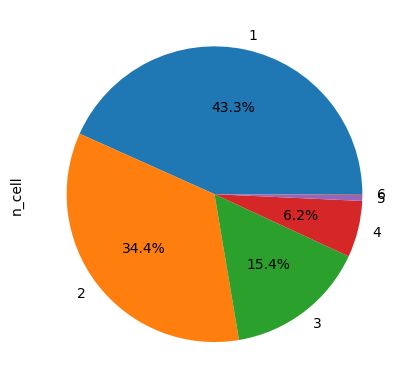

In [71]:
df_memnto_cr_repeat.value_counts("n_celltype").reset_index('n_celltype').rename(columns={0: 'n_cell'}).set_index('n_celltype').plot.pie(
    y='n_cell',
    autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
    legend=False
)


In [72]:
df_degmemento_cr_repeat

,condition,gene,ctname
1343,MC,Garnl3,6
5044,MW,Mical2,5
995,MC,Drg1,5
3149,MC,Sergef,5
3557,MC,Tef,5
...,...,...,...
2532,MC,Peli3,1
2531,MC,Peli2,1
2530,MC,Peli1,1
2529,MC,Peg3,1


In [73]:
df_degmemento_cr.loc[:,['ctname','condition','gene']].groupby(['condition','gene']).count().reset_index()

,condition,gene,ctname
0,MC,1110038F14Rik,2
1,MC,1110059E24Rik,1
2,MC,1500004A13Rik,3
3,MC,1500009L16Rik,1
4,MC,1500011B03Rik,1
...,...,...,...
5923,MW,Znhit1,1
5924,MW,Znrf2,1
5925,MW,Zscan22,2
5926,MW,Zswim6,1


In [74]:
df_memento_dbatch.rename(columns={'gene_name': 'gene'}, inplace=True)
df_degmemento_dbatch = df_memento_dbatch.merge(df_deg_select, how='inner', left_on=['ctname', 'condition', 'gene'], right_on=['ctname', 'condition', 'gene'], suffixes=('_atac', '_sc'))
for ctname in df_degmemento_dbatch.ctname.unique():
    df_ct = df_degmemento_dbatch[df_degmemento_dbatch.ctname == ctname]
    df_s_deg = df_deg[df_deg.ctname == ctname]
    df_s_dar = df_memento_dbatch[df_memento_dbatch.ctname == ctname]
    corr = df_ct[['de_coef_atac', 'de_coef_sc']].corr(method='pearson').iloc[0, 1]
    IoU = len(df_ct.drop_duplicates(['gene'])) / len(set(df_s_deg.gene).union(set(df_s_dar.gene)))
    row = pd.DataFrame({
        'ctname': ctname,
        'corr': corr,
        'IoU': IoU,
        'size': len(df_ct),
        'method': "memento_batch_cov"
    }, index=[0])
    df_result_all = pd.concat([df_result_all, row], ignore_index=True)
    print(f'Correlation for {ctname}: {corr:.2f},size={len(df_ct.drop_duplicates(subset=["gene"]))}, IoU={IoU:.2f}')

Correlation for PFC_Glut: 0.26,size=1189, IoU=0.07
Correlation for PFC_GABA: 0.68,size=358, IoU=0.03
Correlation for HIP_Glut: 0.72,size=1944, IoU=0.13
Correlation for HIP_GABA: 0.02,size=902, IoU=0.09
Correlation for AMY_GABA: 0.25,size=2067, IoU=0.18
Correlation for AMY_Glut: 0.74,size=2101, IoU=0.14


In [75]:
df_mementob_old.rename(columns={'gene_name': 'gene'}, inplace=True)
df_degmementob_old = df_mementob_old.merge(df_deg_select, how='inner', left_on=['ctname', 'condition', 'gene'], right_on=['ctname', 'condition', 'gene'], suffixes=('_atac', '_sc'))
for ctname in df_degmementob_old.ctname.unique():
    df_ct = df_degmementob_old[df_degmementob_old.ctname == ctname]
    df_s_deg = df_deg[df_deg.ctname == ctname]
    df_s_dar = df_mementob_old[df_mementob_old.ctname == ctname]
    corr = df_ct[['de_coef_atac', 'de_coef_sc']].corr(method='pearson').iloc[0, 1]
    IoU = len(df_ct.drop_duplicates(['gene'])) / len(set(df_s_deg.gene).union(set(df_s_dar.gene)))
    row = pd.DataFrame({
        'ctname': ctname,
        'corr': corr,
        'IoU': IoU,
        'size': len(df_ct),
        'method': "memento"
    }, index=[0])
    df_result_all = pd.concat([df_result_all, row], ignore_index=True)
    print(f'Correlation for {ctname}: {corr:.2f},size={len(df_ct.drop_duplicates(subset=["gene"]))}, IoU={IoU:.2f}')

Correlation for PFC_Glut: 0.26,size=1267, IoU=0.07
Correlation for PFC_GABA: 0.69,size=404, IoU=0.03
Correlation for HIP_GABA: 0.01,size=941, IoU=0.09
Correlation for HIP_Glut: 0.71,size=1904, IoU=0.13
Correlation for AMY_Glut: 0.74,size=2108, IoU=0.15
Correlation for AMY_GABA: 0.25,size=2099, IoU=0.18


In [76]:
df_result_all

,ctname,corr,IoU,size,method
0,PFC_Glut,0.038048,0.053931,6834,wilcoxon
1,PFC_GABA,0.448743,0.003133,72,wilcoxon
2,AMY_Glut,0.524133,0.006141,143,wilcoxon
3,HIP_Glut,-0.057854,0.049938,1466,wilcoxon
4,AMY_GABA,0.034897,0.007811,185,wilcoxon
5,HIP_GABA,NaN,0.000044,1,wilcoxon
6,PFC_Glut,0.022370,0.234669,7314,memento_cr_cov
7,PFC_GABA,0.015662,0.129080,1920,memento_cr_cov
8,HIP_Glut,0.538453,0.119219,2300,memento_cr_cov
9,HIP_GABA,0.011188,0.095653,1063,memento_cr_cov


<Axes: xlabel='ctname', ylabel='corr'>

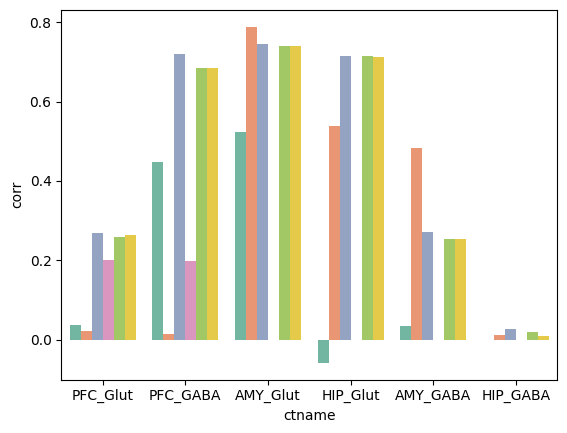

In [77]:
sns.barplot(
    data=df_result_all,
    x='ctname',
    y='corr',
    hue='method',
    legend=False,
    palette=sns.color_palette("Set2", n_colors=len(df_result_all.method.unique()))
)

<Axes: xlabel='ctname', ylabel='IoU'>

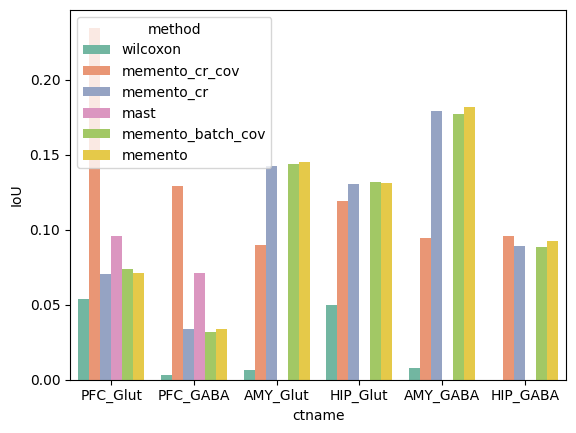

In [78]:
sns.barplot(
    data=df_result_all,
    x='ctname',
    y='IoU',
    hue='method',
    palette=sns.color_palette("Set2", n_colors=len(df_result_all.method.unique()))
)

In [ ]:
df_memento_cr

In [ ]:
df_memento_cr['regulation'] = df_memento_cr['condition'].apply(lambda x: 'Up' if x == 'MC' else 'Down')

In [ ]:
df_memento_cr['celltype.L1'] = df_memento_cr['ctname'].apply(lambda x: x.split('_')[-1])

In [ ]:
df_memento_cr.columns

In [ ]:
df_memento_cr.drop(['regularion'],axis=1,inplace=True)

In [ ]:
df_memento_cr.merge(df_memnto_cr_repeat, how='left', on=['condition', 'gene']).rename(columns={'darct': 'Neu_subtype','n_celltype':'#Neuron_type'}).to_csv('/data2st1/junyi/output/atac0526/dar/region_nt/mementob_dar_noccur.csv', index=False)

In [ ]:
def plot_stack_prop(df,x=None, y='proportion',pro_col='celltype.L1',color_palette=sns.color_palette("Set2"), figsize=(10, 6),x_order=None, **kwargs):
    counts = df.groupby([x, pro_col]).size().unstack(fill_value=0)
    # If x_order is provided, sort the index of counts
    if x_order is not None:
        counts = counts.loc[x_order]
    df_prop = counts.div(counts.sum(axis=1), axis=0) * 100
    df_prop = df_prop.reset_index().melt(id_vars=x, var_name=pro_col, value_name=y)
    fig, ax = plt.subplots(figsize=figsize)
    sns.set(style="whitegrid")
    # Initialize bottom positions for stacking
        # Sort the dataframe by the specified order by the column of sample name
    bottom = pd.Series([0] * len(df_prop[x].unique()), index=df_prop[x].unique())
    # Plot each celltype layer
    for i, celltype in enumerate(df_prop[pro_col].unique()):
        subset = df_prop[df_prop[pro_col] == celltype]
        sns.barplot(
            x=x, y=y, data=subset,
            label=celltype, bottom=bottom[subset[x]],
            color=color_palette[i]
        )
        bottom += subset.set_index(x)[y].reindex(bottom.index, fill_value=0)
    ax.set_title('Celltype Proportions per Sample')
    ax.set_ylabel('Proportion (%)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.legend(title='Celltype', bbox_to_anchor=(1.05, 1))
    return fig,ax

#order = meta_atac.sort_values('Region')['sample'].unique()
df_memento_cr['ctname_con'] = df_memento_cr['region'].astype(str) +"_"+ df_memento_cr['ctname'].str.split('_').str[-1].astype(str) + "_" + df_memento_cr['regulation'].astype(str)
order = df_memento_cr.sort_values(by=['celltype.L1','regulation']).drop_duplicates(['ctname_con']).ctname_con.to_list()
plot_stack_prop(df_memento_cr,x='ctname_con', y='proportion',pro_col="primary_region",x_order=order, figsize=(10, 6))

In [ ]:
df_memento_cr

In [ ]:
plot_stack_prop(df_memento_cr,x='ctname_con', y='proportion',pro_col="secondary_region",x_order=order, figsize=(10, 6))

In [ ]:
df_memento_cr.to_csv('/data2st1/junyi/output/atac0526/dar/region_nt/mementob_cr_annotated.csv', index=False)

In [ ]:
celltypes = ['Glut', 'GABA']
regions = ['AMY', 'HIP', 'PFC']
condtion = ['MC', 'MW']

for celltype in celltypes:
    for region in regions:
        for con in condtion:
        # read the network genertaed by CICRE
            region2 = region+"_"+region
            df_network = pd.read_csv(f'/data1st2/junyi/output/atac0416/cicre/region_nt/{region2}_{celltype}_{con}_circe_network.csv', index_col=0)
            distance = df_network.Peak1.str.split('_').str[1].astype(int) -df_network.Peak2.str.split('_').str[1].astype(int)
            distance[distance.abs()<500_000].abs().hist(bins=100)
            plt.axvline(x=np.median(distance[distance.abs()<500_000].abs()), color='r', linestyle='-' )  # y=position, color, linestyle
        # plt.text(np.median(distance[distance.abs()<500_000].abs()) +10000, 25000, , color='k')  # Position text at (x=1, y=5.1)
            plt.title(f'Median distance:{np.median(distance[distance.abs()<500_000].abs())}')
            plt.savefig(f'/data1st2/junyi/output/atac0416/cicre/region_nt/{region2}_{celltype}_{con}_circe_network_distance.png')
            plt.close()


In [ ]:
df_network